In [1]:
using PyPlot
include("saltsolver.jl")
include("passive.jl")

/Users/davidliu/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


passive_solve! (generic function with 1 method)

In [2]:
nsym = 4
ℓ = 1
Lcav = 1.0

# uniform
wantcnv = true
σ = 0.1
ɛrpiece = [1.0]
ɛipiece = [σ]
Fpiece = [1.0]

ɛr = cn_profile(ɛrpiece, nsym)
ɛi = cn_profile(ɛipiece, nsym)
ɛ = ɛr + im*ɛi
F = cn_profile(Fpiece, nsym)

ismirror(v) = (v == ring_flip(v))
iscnv = (ismirror(ɛ) && ismirror(F))
assert(wantcnv == iscnv)

N = length(F)
assert(N == nsym)
h = Lcav / N
laplacian!(J) = periodic!(J, h)
Eguess, ωguess = ring_eigenpair(N, ℓ, h)

# purposely make it far from gain center to 
# see low-Q effects
ωa = round(ωguess) + 1
γ⟂ = 0.7
γpar = 0.1
las = Laser(ɛ, F, ωa, γ⟂);

In [ ]:
nsym = 8
ℓ = 2
Lcav = 1.0

wantcnv = true
if wantcnv
    ɛrpiece = [1.0, 1.1, 1.1]
    ɛipiece = [0.3, 0.25, 0.25]
    Fpiece = [1.1, 0.9, 0.9]
else 
    ɛrpiece = [1.0, 1.2, 1.1]
    ɛipiece = [0.3, 0.25, 0.32]
    Fpiece = [1.1, 0.9, 0.95]
end
    
ɛr = cn_profile(ɛrpiece, nsym)
ɛi = cn_profile(ɛipiece, nsym)
ɛ = ɛr + im*ɛi
F = cn_profile(Fpiece, nsym)

ismirror(v) = (v == ring_flip(v))
iscnv = (ismirror(ɛ) && ismirror(F))
assert(wantcnv == iscnv)

N = length(F)
h = Lcav / N
laplacian!(J) = periodic!(J, h)
Eguess, ωguess = ring_eigenpair(N, ℓ, h)

# purposely make it far from gain center to 
# see low-Q effects
ωa = round(ωguess) + 1
γ⟂ = 0.7
γpar = 0.1
las = Laser(ɛ, F, ωa, γ⟂);

In [3]:
Dguess = 2.5 * mean(ɛipiece)
md = Mode(copy(Eguess), ωguess, 0.0)
Dt = threshold!(laplacian!, md, las, (Dguess, Dguess*1.05))

println("threshold search slightly breaks pure chirality")
println("use projection operator to get it back")
md = Mode(project_chiral(md.E, nsym, ℓ), md.ω, md.c²)
println("chiral-projected mode should automatically be solution")
solve!(laplacian!, md, las, Dt, isprint=true)
println("ℓ eigenvalue and residual:\n", get_ell(md.E, nsym))

fmd = mode_flip(md)
if iscnv
    println("Cnv, so flipped solved immediate")    
else
    println("Cn only, so flipped solve not immediate")
end
solve!(laplacian!, fmd, las, Dt, isprint=true)
if !iscnv
    fmd = Mode(project_chiral(fmd.E, nsym, -ℓ), fmd.ω, fmd.c²)
    println("reprojecting fmd to fix slightly broken chiral symmetry")
    println("reprojected fmd should immediately solve Newton")
    solve!(laplacian!, fmd, las, Dt, isprint=true)
end
println("ℓ eigenvalue and residual:\n", get_ell(fmd.E, nsym))

println("\ncheck that degenerate and at threshold")
println("ω₊ - ω₋ = ", md.ω - fmd.ω)
println("|c₊²|+|c₋²| = ", abs(md.c²) + abs(fmd.c²))
Es = (md.E, fmd.E)
ωt = md.ω
H, I, J, K, GD = overlap_integrals(Es, ωt, Dt, las, nsym, ℓ, Lcav);

threshold search slightly breaks pure chirality
use projection operator to get it back
chiral-projected mode should automatically be solution
|f| = 2.6824700799425353e-10
ℓ eigenvalue and residual:
(1.0,9.139140943785752e-27)
Cnv, so flipped solved immediate
|f| = 2.6824700799425353e-10
ℓ eigenvalue and residual:
(-1.0,9.139140943785752e-27)

check that degenerate and at threshold
ω₊ - ω₋ = 0.0
|c₊²|+|c₋²| = 5.7188667845170884e-11


In [4]:
# CIRCULATING MODES
ω1s = [0.0, 0.0]
a²ths = [0.0, 0.0]
for m in (1, 2)
    ω1s[m] = -imag(GD / I[m]) / imag(H / I[m])
    a²ths[m] = real((ω1s[m]*H+GD) / I[m])
end

m = 2
d = 0.0001
Dlasing = Dt*(1+d)
a² = a²ths[m]
ω1 = ω1s[m]
md = Mode(copy(Es[m]), ωt+ω1*d, d * a²)
solve!(laplacian!, md, las, Dlasing, isprint=true)
Esalt = √md.c² * md.E
ωsalt = md.ω

println("expected a² = ", a²)
println("actual   a² = ", md.c² / d)
println("expected ω1 = ", ω1)
println("actual   ω1 = ", (md.ω-ωt)/d)

println("\n theoretical stability eigenvalues:")
imjh = imag(J[m]/H)
term = (abs(K[m])^2 - abs(J[m])^2) / abs(H)^2
other_val(z) = a²*(imjh + z*√(0.0im + imjh^2 + term))
println(0.0)
println(other_val(1))
println(other_val(-1))
println(2a² * imag(I[m] / H))

println("\nnumerical stability eigenvalues")
Λsmallest = smallest_stability_eigs(laplacian!, Esalt, ωsalt, Dlasing, γpar, las.ɛ)
for λ in Λsmallest
    println(λ / d)
end

|f| = 6.182418998011502e-10
expected a² = 1.0
actual   a² = 1.0
expected ω1 = -0.0
actual   ω1 = 0.0

 theoretical stability eigenvalues:
0.0
0.0 + 0.0im
-1.0753078882084555 - 0.0im
-1.0753078882084555

numerical stability eigenvalues
3.244675171500673e-7 + 0.0im
3.244778226702857e-7 + 0.0im
-1.0763781173604423 + 0.0im
-1.0763781173804339 + 0.0im


n = 4|ℓ|; expecting zeros at mπ/2 exactly because Cnv
a² differs across roots because ±i and ±1 solutions
standing lasing mode E = |a₊|E₊ exp(iθ)|a₋|E₋
θ1 = -2.0000000000000004 × π/2
ω1[1] = 2.06605337684706e-16
  |a₊|²[1] = 0.24999999999999986
  |a₋|²[1] = 0.24999999999999997
θ2 = -0.9999999996902778 × π/2
ω1[2] = -4.151286911157831e-27
  |a₊|²[2] = 7.52838798667137e16
  |a₋|²[2] = -7.52838798667137e16
θ3 = -0.9999999998988127 × π/2
ω1[3] = -4.1512869111578315e-27
  |a₊|²[3] = 2.4595500473042536e16
  |a₋|²[3] = -2.4595500473042536e16
θ4 = -4.70553302287353e-14 × π/2
ω1[4] = 4.748113321331422e-14
  |a₊|²[4] = 0.24999999999999176
  |a₋|²[4] = 0.2500000000000081
θ5 = 0.0 × π/2
ω1[5] = -0.0
  |a₊|²[5] = 0.24999999999999992
  |a₋|²[5] = 0.24999999999999992
θ6 = 4.705533026243767e-14 × π/2
ω1[6] = -4.748113324732466e-14
  |a₊|²[6] = 0.2500000000000081
  |a₋|²[6] = 0.24999999999999176
θ7 = 0.9999999998988133 × π/2
ω1[7] = -4.151286911157831e-27
  |a₊|²[7] = -2.459536303408906e16
  |a₋|²[7] =

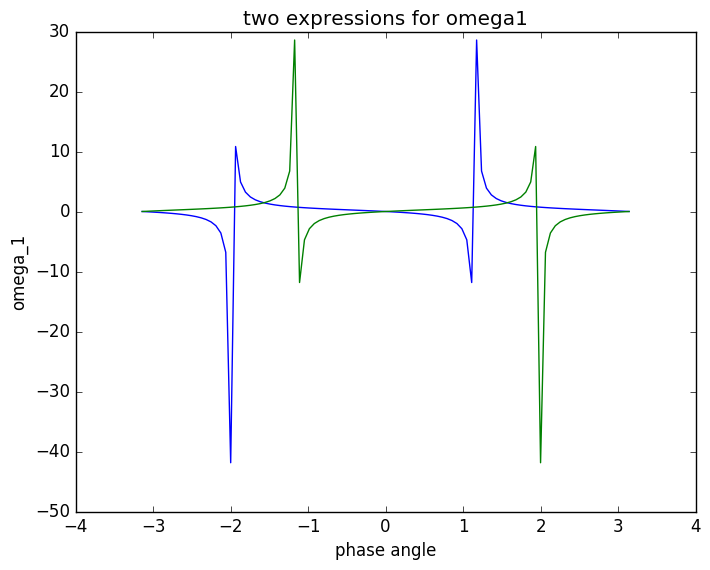

([-3.1415926535897936,-1.570796326308386,-1.570796326635952,-7.391433987941827e-14,0.0,7.391433993235783e-14,1.5707963266359528,1.5707963263084475,3.1415926535897936],[2.06605337684706e-16,-4.151286911157831e-27,-4.1512869111578315e-27,4.748113321331422e-14,-0.0,-4.748113324732466e-14,-4.151286911157831e-27,-4.151286911157831e-27,-2.0660533768470603e-16],[(0.24999999999999986,0.24999999999999997),(7.52838798667137e16,-7.52838798667137e16),(2.4595500473042536e16,-2.4595500473042536e16),(0.24999999999999176,0.2500000000000081),(0.24999999999999992,0.24999999999999992),(0.2500000000000081,0.24999999999999176),(-2.459536303408906e16,2.459536303408906e16),(-7.527436221918576e16,7.527436221918576e16),(0.24999999999999997,0.24999999999999986)])

In [17]:
# get standing mode allowed phases
θroots, ω1roots, a²standing = standing_roots_test(H, I, J, K, GD, iscnv, nsym, ℓ, maxits=15)

In [30]:
real(im*(3+5im)) == -imag(3+5im)

true

In [34]:
# for N = 4ℓ uniform z = ±i case, which is
# very special in that |a₊|²+|a₋|²=1 is the only constraint
# notice you can select a₊² anything and SALT is still solved immediately
d = 0.0001
z = -1im  # either im or -im is fine
Dlasing = Dt * (1+d)
a₊² = 0.273
assert(0 < a₊² < 1)
a₋² = 1 - a₊²
Esalt_guess = √a₊² * Es[1] + z * √a₋² * Es[2]
ωsalt_guess = ωt # uniform case ω1 = 0
md = Mode(copy(Esalt_guess), ωsalt_guess, 0.0)
c²guess = d * norm(Esalt_guess)^2 / norm(md.E)^2
md.c² = c²guess
solve!(laplacian!, md, las, Dlasing, isprint=true)

# hack; standing_roots function does not work for 
# this special case because T± singular
θroots = [π/2, -π/2]
ω1roots = [0, 0]
a²standing = ((a₊², a₋²), (a₊², a₋²))

|f| = 6.182418998011528e-10


((0.273,0.727),(0.273,0.727))

In [35]:
mroot = 1
d = 0.0001
Dlasing = Dt * (1+d)
a²s = a²standing[mroot]
θroot = θroots[mroot]
Esalt_guess = √a²s[1] * Es[1] + exp(im*θroot) * √a²s[2] * Es[2]
ωsalt_guess = ωt + d * ω1roots[mroot]
md = Mode(copy(Esalt_guess), ωsalt_guess, 0.0)
c²guess = d * norm(Esalt_guess)^2 / norm(md.E)^2
md.c² = c²guess
solve!(laplacian!, md, las, Dlasing, isprint=true)
coefs = √md.c² * collect(coefficients( md.E, Es))
Esalt = √md.c² * md.E
ωsalt = md.ω
println("expected c² = ", c²guess)
println("actual   c² = ", md.c²)

println("expected ω1 = ", ω1roots[mroot])
println("actual   ω1 = ", (md.ω - ωt)/d)
for m in (1, 2)
    println("coefficient |a_", m, "|^2:")
    println("\texpected: ", a²s[m])
    println("\tactual:   ", abs(coefs[m])^2/d)
end
println("expected θ = ", θroot)
println("actual   θ = ", angle(coefs[2]/coefs[1]))

println("\nnumerical stability eigenvalues")
Λsmallest = smallest_stability_eigs(laplacian!, Esalt, ωsalt, Dlasing, γpar, las.ɛ)
for λ in Λsmallest
    println(λ / d)
end

println("\ntheoretical stability eigenvalues")
z = exp(im*θroot)
a₊a₋ = sqrt(a²s[1]*a²s[2])
a₊², a₋² = a²s 
# be careful to either say 1 + 1 or 1+1 here, not 1 +1 or else
# it will get interpreted as the next column!
XQmP̃ = [2a₋²*K[2]*z^2   a₊a₋*((z-1/z)*(I[2]+J[2]) - 2z*K[2]) ;
        -2a₊a₋/z*K[1]       a₋²*(z^2-1)*I[2] + a₊²*K[1]*(1+z^-2)     ]
XQpP̃ = [2a₊²*I[1]      a₊a₋*((z+1/z)*(I[2]+J[2]) + 2z*K[2]); 
    2a₊a₋*(z*(I[1] + J[1]) + 1/z*K[1])    a₋²*(z^2+1)*I[2] + a₊²*K[1]*(1-z^-2)] 
MatFinal = [ imag(XQpP̃/H)   -real(XQmP̃/H);
            -real(XQpP̃/H)  -imag(XQmP̃/H) ]

Λfinal, ~ = eig(MatFinal)
Λfinal = Λfinal[sortperm(abs(Λfinal))]
for λ in Λfinal
    println(λ)
end

i₊, i₋ = I[1]/H, I[2]/H
j₊, j₋ = J[1]/H, J[2]/H
k₊, k₋ = K[1]/H, K[2]/H
zr, zi = real(z), imag(z)
MatFinalAlternate_first2cols = 
2*[ a₊² * imag(i₊)      a₊a₋*(zr*imag(i₋ + j₋) + imag(z*k₋));
    a₊a₋*imag(z*(i₊ + j₊)+1/z*k₊)     a₋²*zr*imag(z*i₋) + a₊²*real(1/z*k₊)*zi;
    -a₊² * real(i₊)      -a₊a₋*(zr*real(i₋+j₋) + real(z*k₋));
    -a₊a₋*real(z*(i₊+j₊)+1/z*k₊)    -a₋²*zr*real(z*i₋) + a₊²*imag(1/z*k₊)*zi]
MatFinalAlternate_second2cols = 
2*[ -a₋²*real(k₋*z^2)   a₊a₋*(zi*imag(i₋+j₋) + real(z*k₋));
    a₊a₋*real(1/z*k₊)   a₋²*zi*imag(z*i₋) - a₊²*real(1/z*k₊)*zr;
    -a₋²*imag(k₋*z^2)   -a₊a₋*(zi*real(i₋+j₋) - imag(z*k₋));
    a₊a₋*imag(1/z*k₊)   -a₋²*zi*real(z*i₋) - a₊²*imag(1/z*k₊)*zr]
MatFinalAlternate = [MatFinalAlternate_first2cols  MatFinalAlternate_second2cols]
println("\nnorm(MatFinal - MatFinalAlternate) = ", norm(MatFinalAlternate - MatFinal))


if nsym==4abs(ℓ) && iscnv
    println("\nclosed-form theoretical predictions for Cnv with n==4ℓ:")
    isrealz = iseven(round(Int, θroot/(π/2)))
    println("standing solution with z = ", isrealz ? "±1" : "±i")
    vals = [0.0, 0.0, 0.0, 0.0] + 0im
    vals[1] = 0.0
    
    α = isrealz ? 1 : -1
    # I have no idea what to name this!
    
    vals[2] = 2a₊² * imag(2i₊ + j₊ + α*k₊)
    radicand = 0.0im + imag(k₊ - α * j₊)^2 - α * 8real(k₊)*real(j₊ + α * k₊)
    vals[3] = -a₊² * imag(j₊ + α * 3k₊) + a₊² * √radicand
    vals[4] = -a₊² * imag(j₊ + α * 3k₊) - a₊² * √radicand
    abslt(x, y) = abs(x) < abs(y)
    sort!(vals, lt=abslt)
    for λ in vals
        println(λ)
    end
    
    for sn in (1, -1)
        Mat = nothing
        if isrealz
            Mat = 2a₊² * [imag(i₊)   sn*imag(i₋+j₋+k₋)   -√2*real(k₋);
                sn*imag(i₊+j₊+k₊)    imag(i₋)         √2*sn*real(k₊);
                1/√2*real(j₊+k₊)       -1/√2*sn*real(j₋+k₋)  -imag(k₋)-imag(k₊)]
        else
            Mat = 2a₊² * [
                imag(i₊)    sn*√2*real(k₋)    sn*imag(i₋+j₋-k₋);
                sn/√2*real(j₊-k₊)   imag(k₊+k₋)   -1/√2*real(j₋-k₋);
                sn*imag(i₊+j₊-k₋)   -√2*real(k₊)   imag(i₋)
            ]
        end
        vals, ~ = eig(Mat)
        sort!(vals, lt=abslt)
        println("theoretical eigenvalues from 3x3 problem for z = ", sn*(isrealz ? 1 : 1im))
        for λ in vals
            println("\t", λ)
        end
    end

elseif iscnv && nsym!=4abs(ℓ)
    println("\nclosed-form theoretical predictions for Cnv with n!=4ℓ:")    
    println("two nonzero eigenvalues")
    vals = [0.0, 0.0]
    ss = [1, -1]
    tr0 = 2imag(a₊² * i₊ + a₋² * i₋)
    det0 = -4a₊a₋^2*(imag(i₊)*imag(j₋) + imag(j₊)*imag(i₋) + imag(j₊)*imag(j₋))
    for m = (1, 2)
        vals[m] = tr0/2 + ss[m] * sqrt((tr0/2)^2 - det0)
    end
    # 2a₊²*(imag(i₊) + 2abs(imag(i₊)))
    # also works for TM (J=I), and is provably both signs
    for λ in vals
        println(λ)
    end
end

|f| = 6.182418998011528e-10
expected c² = 0.0001
actual   c² = 0.0001
expected ω1 = 0
actual   ω1 = 0.0
coefficient |a_1|^2:
	expected: 0.273
	actual:   0.2730000000000001
coefficient |a_2|^2:
	expected: 0.727
	actual:   0.7269999999999999
expected θ = 1.5707963267948966
actual   θ = 1.570796326794897

numerical stability eigenvalues
3.244650960450594e-7 + 0.0im
3.245189143447984e-7 + 0.0im
-1.0763781173441076 + 0.0im
-1.076378117434879 + 0.0im

theoretical stability eigenvalues
3.2017997070290305e-17 + 9.237629694118549e-17im
3.2017997070290305e-17 - 9.237629694118549e-17im
-1.0753078882084552 + 0.0im
-1.0753078882084561 + 0.0im

norm(MatFinal - MatFinalAlternate) = 1.310662966091523e-16

closed-form theoretical predictions for Cnv with n==4ℓ:
standing solution with z = ±i
0.0 + 0.0im
5.551115123125783e-17 + 0.0im
-0.5871181069618167 + 0.0im
-0.5871181069618168 - 0.0im
theoretical eigenvalues from 3x3 problem for z = 0 + 1im
	0.0
	-0.5871181069618168
	-0.5871181069618168
theoretical e